In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
import pickle as pk

## 1. The RNN model

In [2]:
class RNN(nn.Module):
    
    def __init__(self, states_dim, causes_dim, output_dim, factor_dim, tau):
        super(RNN, self).__init__()
        
        self.states_dim = states_dim
        self.causes_dim = causes_dim
        self.output_dim = output_dim
        self.factor_dim = factor_dim
        
        # Time constant of the RNN
        self.tau = tau
        
        # Output weights initialization
        self.w_o = torch.randn(self.states_dim, self.output_dim) * 5 / self.states_dim
        
        # Recurrent weights factorization
        self.w_pd = torch.randn(self.states_dim, self.factor_dim) * 0.2 / np.sqrt(self.factor_dim)
        self.w_fd = self.w_pd.clone()
        self.w_cd = torch.nn.Softmax(1)(0.5*torch.randn(self.causes_dim, self.factor_dim))*self.factor_dim
        self.w_pd += torch.randn_like(self.w_pd) / np.sqrt(self.factor_dim)
        self.w_fd += torch.randn_like(self.w_fd) / np.sqrt(self.factor_dim)
        
        # Predictions, states and errors are temporarily stored for batch learning
        # Learning can be performed online, but computations are slower
        self.x_pred = None
        self.error = None
        self.h_prior = None
        self.h_post = None
        self.s = None
        
    def forward(self, x, c_init, h_init=0, lr_c=0.2, lr_h=0.2):
        """
        Pass through the network : forward (prediction) and backward (inference) passes are 
         performed at the same time. Online learning could be performed here, but to improve
         computations speed, we use the seq_len as a batch dimension in a separate function.
        Parameters :        
        - x : target sequences, Tensor of shape (seq_len, batch_size, output_dim)
        - c_init : causes of the sequences, Tensor of shape (batch_size, causes_dim)
        - h_init : states of the sequences, Tensor of shape (batch_size, states_dim)
        - lr_c : learning rate associated with the hidden causes, double
        - le_h : learning rate associated with the hidden state, double
        """

        
        seq_len, batch_size, _ = x.shape
        
        # Temporary storing of the predictions, states and errors
        x_pred = torch.zeros_like(x)
        h_prior = torch.zeros(seq_len, batch_size, self.states_dim)
        h_post = torch.zeros(seq_len, batch_size, self.states_dim)
        c = torch.zeros(seq_len+1, batch_size, self.causes_dim)
        error_h = torch.zeros(seq_len, batch_size, self.states_dim)
        error = torch.zeros_like(x)
        
        # Initial hidden state and hidden causes
        c[0] = c_init
        old_h_post = h_init
        
        for t in range(seq_len):
            
            # Top-down pass
            
            # Compute h_prior according to past h_post and c
            h_prior[t] = (1-1/self.tau) * old_h_post + (1/self.tau) * torch.mm(
                torch.mm(
                    torch.tanh(old_h_post),
                    self.w_pd
                ) * torch.mm(
                    c[t],
                    self.w_cd
                ),
                self.w_fd.T
            )  
            
            # Compute x_pred according to h_prior
            x_pred[t] =  torch.mm(torch.tanh(h_prior[t]), self.w_o)

            # Bottom-up pass
            
            # Compute the error on the sensory level
            error[t] = x_pred[t] - x[t]
            
            # Infer h_post according to h_prior and the error on the sensory level
            h_post[t] = h_prior[t] - (1-torch.tanh(h_prior[t])**2)*lr_h*torch.mm(error[t], self.w_o.T)

            # Compute the error on the hidden state level
            error_h[t] = h_prior[t] - h_post[t]
            
            # Infer c according to its past value and the error on the hidden state level
            c[t+1] = c[t] - lr_c*torch.mm(
                torch.mm(
                    torch.tanh(old_h_post),
                    self.w_pd
                )* torch.mm(
                    error_h[t],
                    self.w_fd
                ),
                self.w_cd.T
            )
            
            old_h_post = h_post[t]
        
        self.x_pred = x_pred
        self.error = error
        self.error_h = error_h
        self.h_prior = h_prior
        self.h_post = h_post
        self.c = c

    def learn(self, lr_o, lr_r):
        """
        Performs learning of the RNN weights. For computational efficieny, sequence length and
         batch size are merged into a single batch dimension in the following computations
        Parameters :
        - lr_o : Learning rate for the output weights
        - lr_r : Learning rate for the recurrent weights
        """

        
        seq_len, batch_size, _ = self.x_pred.shape
        
        # Output weights
        grad_o = lr_o * torch.mean(
            torch.bmm(
                torch.tanh(self.h_prior.reshape(seq_len * batch_size, self.states_dim, 1)),
                self.error.reshape(seq_len * batch_size, 1, self.output_dim)
            ),
            axis=0
        )
        
        self.w_o -= grad_o
        
        nbatch = (seq_len-1)*batch_size
                
        # Recurrent weights
        grad_pd = lr_r * torch.mean(
            torch.bmm(
                torch.tanh(self.h_post[:-1]).reshape(nbatch, self.states_dim, 1),
                (
                    torch.mm(
                        self.error_h[1:].reshape(nbatch, self.states_dim),
                        self.w_fd
                    ) * \
                    torch.mm(
                        self.c[1:-1].reshape(nbatch, self.causes_dim),
                        self.w_cd
                    )
                ).reshape(nbatch, 1, self.factor_dim)
            ),
            axis=0
        )
        
        self.w_pd -= grad_pd
        
        grad_cd = 10 * lr_r * torch.mean(
            torch.bmm(
                self.c[1:-1].reshape(nbatch, self.causes_dim, 1),
                (
                    torch.mm(
                        self.error_h[1:].reshape(nbatch, self.states_dim),
                        self.w_fd
                    ) * \
                    torch.mm(
                        torch.tanh(self.h_post[:-1]).reshape(nbatch, self.states_dim),
                        self.w_pd
                    )
                ).reshape(nbatch, 1, self.factor_dim)
            ),
            axis=0
        )
        self.w_cd -= grad_cd
        
        grad_fd = lr_r * torch.mean(
            torch.bmm(
                torch.tanh(self.error_h[1:]).reshape(nbatch, self.states_dim, 1),
                (
                    torch.mm(
                        torch.tanh(self.h_post[:-1]).reshape(nbatch, self.states_dim),
                        self.w_pd
                    ) * \
                    torch.mm(
                        self.c[1:-1].reshape(nbatch, self.causes_dim),
                        self.w_cd
                    )
                ).reshape(nbatch, 1, self.factor_dim)
            ),
            axis=0
        )
        
        self.w_fd -= grad_fd

## 2. Load the dataset of handwritten trajectories

In [3]:
import scipy.io as sio

# The dataset can be downloaded here : https://archive.ics.uci.edu/ml/datasets/Character+Trajectories

# Loading and preprocessing of the dataset
trajectories = sio.loadmat('data/mixoutALL_shifted.mat')['mixout'][0]
trajectories = [trajectory[:, np.sum(np.abs(trajectory), 0) > 1e-3] for trajectory in trajectories]
trajectories = [np.cumsum(trajectory, axis=-1) for trajectory in trajectories]

# Normalize dataset trajectory length
traj_len = 60
normalized_trajectories = np.zeros((len(trajectories), 2, traj_len))
for i, traj in enumerate(trajectories):
    tlen = traj.shape[1]
    for t in range(traj_len):
        normalized_trajectories[i, :, t] = traj[:2, int(t*tlen/traj_len)]

# Rescale the trajectories
trajectories = normalized_trajectories/10

In [4]:
# Index ranges corresponding to the three first classes (a, b, c)
labels_range = np.zeros((3, 2))
labels_range[0] = np.array([0, 97])
labels_range[1] = np.array([97, 170])
labels_range[2] = np.array([170, 225])

## 3. Train the visual prediction RNN

In [5]:
# Number of training iterations
iterations = 2000

# Number of trajectory classes
p = 3

# Dimension of the RNN hidden state
states_dim = 100
batch_size = p * 20

# Select 20 trajectories per class for training (20 other will be used for testing)
traj = torch.cat([
    torch.Tensor(trajectories[int(labels_range[k][0]):int(labels_range[k][0])+20])
    for k in range(p)
]).transpose(1, 2).transpose(0, 1)

# Initialize the RNN
rnn = RNN(states_dim=states_dim, causes_dim=p, output_dim=2, factor_dim=states_dim//2, tau=7)

# Initial hidden causes and hidden state of the RNN
c_init = torch.eye(p)
h_init = torch.randn(1, rnn.states_dim).repeat(p, 1)
c_init = c_init.unsqueeze(1).repeat(1, 20, 1).reshape(batch_size, p)
h_init = h_init.unsqueeze(1).repeat(1, 20, 1).reshape(batch_size, rnn.states_dim)

# Store the prediction errors throughout training
errors = np.zeros(iterations)

# Train the network
for i in tqdm(range(iterations)):

    # Learning rates
    lr_o = 0.1/(2**(i//1000))
    lr_r = 3

    # Forward (prediction and inference) pass through the RNN
    c = c_init.clone()
    h = h_init.clone()
    rnn.forward(traj, c, h, lr_c=0.0, lr_h=0.001)
    
    # Learning 
    rnn.learn(lr_o, lr_r)

    # Store the prediction error
    errors[i] = torch.mean(rnn.error**2).item()

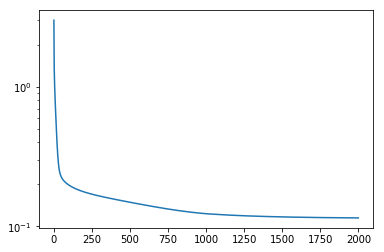

In [6]:
plt.plot(errors)
plt.yscale('log')
plt.show()

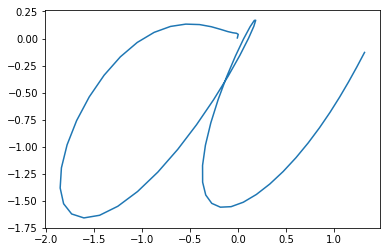

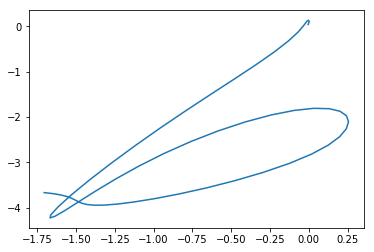

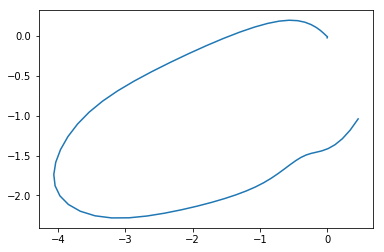

In [18]:
rnn.forward(torch.zeros(60, batch_size, 2), c_init.clone(), h_init.clone(), lr_c=0.0, lr_h=0.0)
for k in range(p):
    plt.figure()
    plt.plot(rnn.x_pred[:, k*20, 0], rnn.x_pred[:, k*20, 1])
    plt.show()

## 4. AIF control model

In [8]:
def forward_model(x):
    """
    Forward model predicting the next observation based on the current observation and action
    Parameters :
    - x : Tensor of shape (seq_len, batch_size, joints) angle
    Returns : Tensor of shape (seq_len, batch_size, 2) corresponding to the trajectory in euclidean coordinates
    """
    x = x.clone()
    lens = [6, 4, 2]
    seq_len = x.shape[0]
    batch_size = x.shape[1]
    joints = x.shape[2]
    
    pos = torch.zeros(seq_len, batch_size, 2) - 6
    angles = torch.Tensor([0, np.pi/2, 0]).unsqueeze(0).unsqueeze(0).repeat(seq_len, batch_size, 1) + 0.25*np.pi*torch.tanh(x)
    
    angle = 0
    for j in range(joints):
        pos[:, :, 0] += lens[j] * torch.cos(angle + angles[:, :, j])
        pos[:, :, 1] += lens[j] * torch.sin(angle + angles[:, :, j])
        angle += angles[:, :, j]
    
    return pos

In [9]:
class Controller(object):
    """
    Controller class connecting the two RNN generative models
    """
    
    def __init__(self, lr, prnn, mrnn, batch_size, threshold):

        self.batch_size = batch_size
        
        # Perceptual network
        self.prnn = prnn
        self.c_p = None
        self.h_p = None
        self.c_p_init = None
        self.h_p_init = None
        self.sensory_dim = prnn.output_dim
        
        # Motor network
        self.mrnn = mrnn
        self.c_m = None
        self.h_m = None
        self.c_m_init = None
        self.h_m_init = None
        self.motor_dim = mrnn.output_dim
    
        # Sensory prediction
        self.mu = None

        # Learning parameters
        self.lr = lr
        self.optimizer = None
        
        # Threshold for intermittent control
        self.threshold = threshold
    
    def prediction_error(self, m):
        """
        Computes the prediction error associated with a target mu and a value m
        Parameters
        - m : Tensor of shape (batch_size, motor_dim)
        Returns : scalar, squared norm of the prediction error
        """
        o_m = forward_model(m.unsqueeze(0))[0]
        return torch.mean((o_m-self.mu)**2)
    
    def step(self, lr=0.1):
        """
        Performs one step of control
        Parameters
         - lr : double, learning rate used in the motor hidden state update
        Returns
         - control : boolean, whether the output was controlled at this timestep
         - loss : Tensor of shape batch_size, the error between the target and predicted outcome
         - m_target : Tensor of shape (batch_size, 3), the motor target obtained through AIF
         - m_prior : Tensor of shape (batch_size, 3), the motor output predicted at time t
         - m_post : Tensor of shape (batch_size, 3), the motor output that would be predicted with 
          the posterior hidden state
        """
        
        # MRNN prediction
        self.mrnn.forward(
            torch.zeros(1, self.batch_size, self.motor_dim), 
            self.c_m, 
            self.h_m, 
            0, 
            0
        )
        m_prior = self.mrnn.x_pred[0]
        
        # Loss prediction
        loss = self.prediction_error(m_prior)
        
        # Control
        if loss.item() > self.threshold:
            control = True
            
            # We compute the gradient on the output level
            m_target = torch.nn.Parameter(m_prior.clone(), requires_grad=True)
            self.optimizer = torch.optim.SGD([m_target], lr=self.lr)
            self.optimizer.zero_grad()
            loss = self.prediction_error(m_target)
            loss.backward()
            self.optimizer.step()
        
        else: 
            control = False
            m_target = m_prior.clone()
                
        # MRNN state update with the controlled value
        self.mrnn.forward(
            m_target.reshape(1, self.batch_size, self.mrnn.output_dim), 
            self.c_m, 
            self.h_m, 
            0,
            lr
        )
        self.h_m = self.mrnn.h_post[-1]

        # PRNN states and sensory prediction update
        self.update_perceptual_state(forward_model(m_prior.detach().unsqueeze(0))[0])
        
        # Posterior motor prediction
        m_post = torch.mm(torch.tanh(self.h_m), self.mrnn.w_o)
        
        return control, loss, m_target, m_prior, m_post
        
    def reset(self):
        """
        Resets the motor and perceptual states to initiate a new trajectory 
        """
   
        self.c_p = self.c_p_init
        self.h_p = self.h_p_init
        
        self.c_m = self.c_m_init
        self.h_m = self.h_m_init
        
    def update_perceptual_state(self, o, lr_c=0, lr_h=0):
        """
        Updates the perceptual states based on the observation
        Parameters :
        - o : Tensor of shape (batch_size, sensory_dim), the observation resulting from the motor output
        - lr_c : double, learning rate for hidden causes of the PRNN
        - lr_h : double, learning rate for hidden states of the PRNN
        """
        o = o.unsqueeze(0)
        self.prnn.forward(o, self.c_p, self.h_p, lr_c=lr_c, lr_h=lr_h)
        self.c_p = self.prnn.c[-1]
        self.h_p = self.prnn.h_post[-1]
        
        # Update the sensory prediction
        self.update_sensory_prediction()
        
    def update_sensory_prediction(self):
        """
        Updates the sensory prediction made by the perceptual network
        """
        self.prnn.forward(torch.zeros(1, self.batch_size, self.sensory_dim), self.c_p, self.h_p, lr_c=0, lr_h=0)
        self.mu = self.prnn.x_pred[-1]

## 5. Training the motor RNN

In [10]:
# Parameters
iterations=10000

# The perception RNN trained previously
prnn, c_p_init, h_p_init = rnn, c_init, h_init

# Declare motor RNN
mrnn = RNN(states_dim=states_dim, causes_dim=p, output_dim=3, factor_dim=states_dim//2, tau=7)

# Declare controller
controller = Controller(lr=5, prnn=prnn, mrnn=mrnn, batch_size=batch_size, threshold=0.0)

# Initialize the RNNs hidden states and causes
c_m_init = torch.eye(p)
h_m_init = torch.randn(1, mrnn.states_dim).repeat(p, 1)
c_m_init = c_m_init.unsqueeze(1).repeat(1, 20, 1).reshape(batch_size, p)
h_m_init = h_m_init.unsqueeze(1).repeat(1, 20, 1).reshape(batch_size, mrnn.states_dim)
controller.c_p_init = c_p_init
controller.h_p_init = h_p_init
controller.c_m_init = c_m_init
controller.h_m_init = h_m_init

# Store the motor RNN errors through training
errors = np.zeros((iterations))

for i in tqdm(range(iterations)):

    # Reset the motor and perception RNNs
    controller.reset()
    controller.update_sensory_prediction()

    # Save the target trajectory for learning
    target_motor_trajectory = torch.Tensor(traj_len, batch_size, 3)

    for t in range(traj_len):

        # Controller step
        control, loss, m_target, m_prior, m_post = controller.step(lr=0.0001)

        # Save outputs
        target_motor_trajectory[t] = m_target.detach()

    # Learning on the trajectory
    controller.mrnn.forward(target_motor_trajectory, controller.c_m_init, controller.h_m_init, lr_c=0., lr_h=0.0001)
    errors[i] = torch.mean(torch.mean(controller.mrnn.error**2))
    controller.mrnn.learn(0.3, 100)


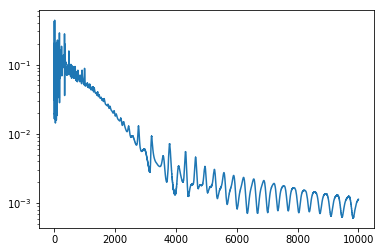

In [12]:
plt.plot(errors)
plt.yscale('log')
plt.show()

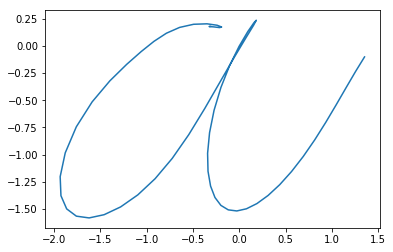

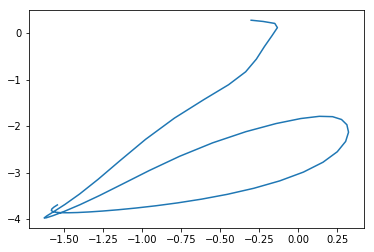

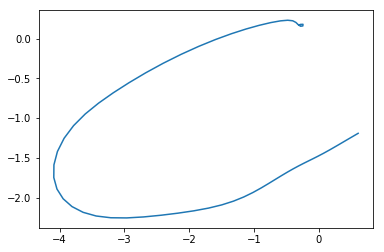

In [19]:
controller.mrnn.forward(target_motor_trajectory, controller.c_m_init, controller.h_m_init, 0., 0.)
visual_trajectory = forward_model(controller.mrnn.x_pred)

for k in range(p):
    plt.figure()
    plt.plot(visual_trajectory[:, k*20, 0], visual_trajectory[:, k*20, 1])
    plt.show()